###  2nd Derivative Image Enhancement

In [1097]:
import statistics
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import math
import cv2
import scipy.signal
import scipy.ndimage
import scipy.io
import sklearn.preprocessing
from PIL import Image
import pybaselines.polynomial

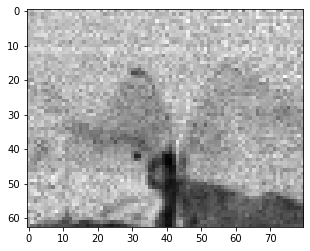

In [1098]:
# get image from file
def get_tumour_image(img_number):
  mat = scipy.io.loadmat(f'./dataset/img{str(img_number)}.mat')
  imgProp = f"xx{str(img_number)}"
  return mat[imgProp]

def get_dental_image(img_number):
  mat = scipy.io.loadmat(f'./crack_images/mix_crack{str(img_number)}.mat')
  imgProp = f"mix_crack{str(img_number)}"
  return mat[imgProp]

def get_fds_image(img_number):
  dat = np.loadtxt(f"./fds/pulse40ms/capstone_sample2_p40ms_ph10ms.dat")
  startIndex = img_number * 64
  img = dat[startIndex:startIndex+63, :]
  return img

def get_interproximal_image(img_number):
  dat = np.loadtxt(f"./fds/interproximal_amp_80ms.dat")
  startIndex = img_number * 64
  img = dat[startIndex:startIndex+63, :]
  return img

def denoise_imageset():
  imgs = []
  for i in range(1, 6):
    dat = np.loadtxt(f"./same_image/Test{str(i)}.dat")
    imgData=dat[0:79, :]
    imgData = cv2.rotate(imgData, cv2.ROTATE_90_CLOCKWISE)
    normalizedData = ((imgData - np.min(imgData)) / (np.max(imgData) - np.min(imgData)) * 255.9).astype(np.uint8) # cv2 multi image requires images to be in UINT-8bit encoding
    imgs.append(normalizedData)
  imgs[0], imgs[2] = imgs[2], imgs[0] # swap positions for best image in the center of the array
  denoised = cv2.fastNlMeansDenoisingMulti(imgs, 2, 5, h=3)
  plt.subplot(131), plt.imshow(imgs[2])
  plt.subplot(132), plt.imshow(denoised)
  plt.subplot(133), plt.imshow(imgs[2] - denoised)
  return

img_number = 5
# denoise_imageset()
# imgData = get_tumour_image(3)
imgData = get_fds_image(0)
# imgData = get_interproximal_image(0)
# imgData = get_dental_image(1)
# imgData = np.array(Image.open("./crack_images/original1-2.png").convert("L"))
plt.imshow(imgData, cmap="gray")

In [1099]:
# images = np.loadtxt("./tileimages.dat")
# index = 1
# imgData=images[index*128:(index+1)*128, :]
# imgData = (imgData - np.min(imgData)) / (np.max(imgData) - np.min(imgData))

In [1100]:
# convert ndarray to list
Img_Matrix = imgData.tolist()

In [1101]:
# function for adding 0 padding to matrix
def Add_Padding(Img_Matrix):
    for i in range(len(Img_Matrix)+1):
        # initialize 1D row
        row=[]
        # Add padding at start of matrix
        if i==0:
            # loop for column
            for j in range(len(Img_Matrix[i])):
                # Append 0 value in row
                row.append(0)
            # Insert row in original image matrix at start
            Img_Matrix.insert(0,row)
        # Add padding at end of matrix
        if i== len(Img_Matrix)-1:
            # Add padding at start and end of matrix in each row
            L=len(Img_Matrix[i])+2
            for j in range(L):
                # Append 0 value in row
                row.append(0)
            # Insert 0 in original image matrix at end of each row
            Img_Matrix.insert(i+1,row)
        # Insert 0 in original image matrix at start of each row    
        Img_Matrix[i].insert(0,0)
        # Append padding in original matrix row
        Img_Matrix[i].append(0)
    return Img_Matrix

In [1102]:
# function for first derivative in vertical direction
def First_Derivative_Vertical(Img_Matrix):
    # find number of rows
    rows = len(Img_Matrix)
    # find number of column
    col = len(Img_Matrix[0])-2
    Vertical_first_Image = []
    # loop for row
    for i in range(1,rows-1):
        # initialize 1d row
        first_D = []
        # loop for column
        for j in range(0,col):
            first = Img_Matrix[i][j+1] - Img_Matrix[i][j]
            first_D.append(first)
        Vertical_first_Image.append(first_D)
    return Vertical_first_Image

In [1103]:
# function for first derivative in horizontal direction
def First_Derivative_Horizontal(Img_Matrix):
    # find number of rows
    rows = len(Img_Matrix)
    # find number of column
    col = len(Img_Matrix[0])
    Horizontal_first_Image = []
    # loop for row
    for i in range(0,rows-2):
        # initialize 1d row
        first_D = []
        # loop for column
        for j in range(1,col-1):
            first = Img_Matrix[i+1][j] - Img_Matrix[i][j]
            first_D.append(first)
        Horizontal_first_Image.append(first_D)
    return Horizontal_first_Image

In [1104]:
# function for second derivative in vertical direction
def Second_Derivative_Vertical(Img_Matrix):
    # find number of rows
    rows = len(Img_Matrix)
    # find number of column
    col = len(Img_Matrix[0])-1
    Vertical_first_Image = []
    # loop for row
    for i in range(1,rows-1):
        # initialize 1d row
        first_D = []
        # loop for column
        for j in range(0,col-1):
            first = (Img_Matrix[i][j+2] + Img_Matrix[i][j] - 2*(Img_Matrix[i][j+1]))
            first_D.append(first)
        Vertical_first_Image.append(first_D)
    return Vertical_first_Image

In [1105]:
# function for second derivative in horizontal direction
def Second_Derivative_Horizontal(Img_Matrix):
    # find number of rows
    rows = len(Img_Matrix)
    # find number of column
    col = len(Img_Matrix[0])
    Horizontal_second_Image = []
    # loop for row
    for i in range(0,rows-2):
        # initialize 1d row
        first_D = []
        # loop for column
        for j in range(1,col-1):
            first = (Img_Matrix[i][j] + Img_Matrix[i+2][j] - 2*(Img_Matrix[i+1][j]))
            first_D.append(first)
        Horizontal_second_Image.append(first_D)
    return Horizontal_second_Image

In [1106]:
# function for second derivative in diagonal "\" direction
def Second_Derivative_Diagonal_TopLeft_BottomRight(Img_Matrix):
    # find number of rows
    rows = len(Img_Matrix)
    # find number of column
    col = len(Img_Matrix[0])
    diagonal_second_Image = []
    # loop for row
    for i in range(1, rows-1):
        # initialize 1d row
        first_D = []
        # loop for column
        for j in range(1, col - 1):
            first = (Img_Matrix[i - 1][j - 1] + Img_Matrix[i + 1][j + 1] - 2*(Img_Matrix[i][j])) / math.sqrt(2)
            first_D.append(first)
        diagonal_second_Image.append(first_D)
    return diagonal_second_Image

In [1107]:
# function for second derivative in diagonal "/" direction
def Second_Derivative_Diagonal_TopRight_BottomLeft(Img_Matrix):
    # find number of rows
    rows = len(Img_Matrix)
    # find number of column
    col = len(Img_Matrix[0])
    diagonal_second_Image = []
    # loop for row
    for i in range(1, rows-1):
        # initialize 1d row
        first_D = []
        # loop for column
        for j in range(1, col - 1):
            first = (Img_Matrix[i - 1][j + 1] + Img_Matrix[i + 1][j - 1] - 2*(Img_Matrix[i][j])) / math.sqrt(2)
            first_D.append(first)
        diagonal_second_Image.append(first_D)
    return diagonal_second_Image

In [1108]:
# function for normalizing array data to 0-255 range
def NormalizeForImageSaving(data):
    return ((data - np.min(data)) / (np.max(data) - np.min(data)) * 255.9).astype(np.uint8)

In [1109]:
# save_og = NormalizeForImageSaving(imgData)
# save_og = Image.fromarray(save_og)
# save_og.save('./outputs/set' + str(img_number) + '.png')

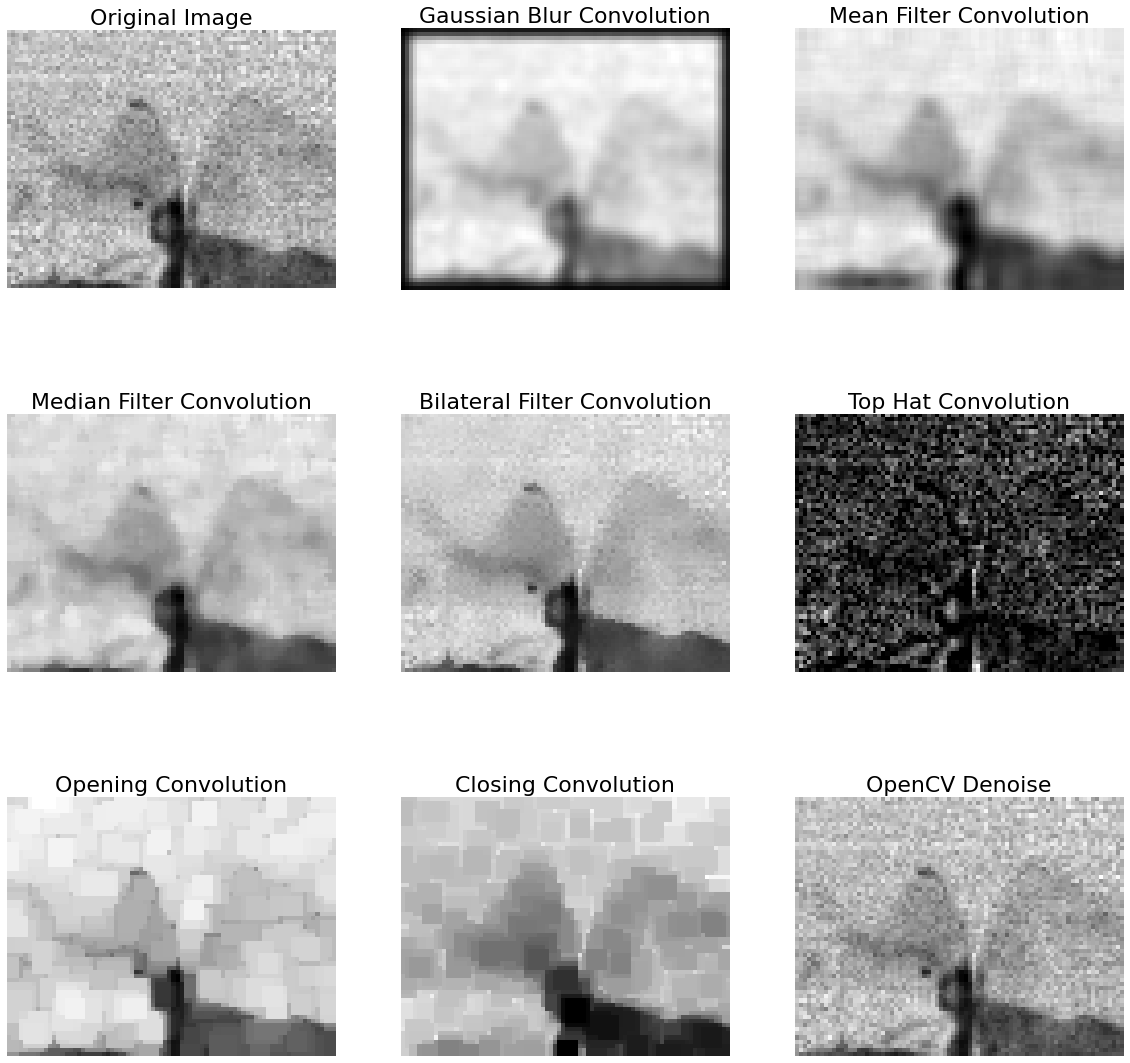

In [1110]:
# compare different convolution kernels' results
imgData = NormalizeForImageSaving(np.array(imgData))
# define convolution kernels
gaussianMatrix = [[1, 2, 3, 2, 1], [2, 4, 6, 4, 2], [3, 6, 9, 6, 3], [2, 4, 6, 4, 2], [1, 2, 3, 2, 1]] # use this for gaussian blur
# gaussianMatrix = [[1, 2, 3, 4, 3, 2, 1], [2, 4, 6, 8, 6, 4, 2], [3, 6, 9, 12, 9, 6, 3], [2, 4, 6, 8, 6, 4, 2], [1, 2, 3, 4, 3, 2, 1]] # use this for gaussian blur
meanMatrix = [[1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1], [1, 1, 1, 1, 1]] # use this for mean filter

# Img_Matrix = scipy.ndimage.median_filter(Img_Matrix, size=(4, 4)) # use this for median filter

gaussian = scipy.signal.convolve2d(Img_Matrix, gaussianMatrix, boundary="fill") # convolve image with kernel
mean = scipy.signal.convolve2d(Img_Matrix, meanMatrix, boundary="symm")
median = scipy.ndimage.median_filter(Img_Matrix, size=(4, 4))
bilateral = cv2.bilateralFilter(NormalizeForImageSaving(np.array(Img_Matrix)), 9, 25, 25)
tophat = cv2.morphologyEx(NormalizeForImageSaving(np.array(Img_Matrix)), cv2.MORPH_TOPHAT, np.array(gaussianMatrix))
opening = cv2.morphologyEx(NormalizeForImageSaving(np.array(Img_Matrix)), cv2.MORPH_OPEN, np.array(gaussianMatrix))
closing = cv2.morphologyEx(NormalizeForImageSaving(np.array(Img_Matrix)), cv2.MORPH_CLOSE, np.array(gaussianMatrix))
cv2denoise = cv2.fastNlMeansDenoising(NormalizeForImageSaving(np.array(Img_Matrix)), None, 3)

fig, axs = plt.subplots(3, 3,figsize=(20,20))

axs[0][0].imshow(Img_Matrix,cmap='gray')
axs[0][0].axis('off')
axs[0][0].set_title('Original Image',fontsize=22)

axs[0][1].imshow(gaussian,cmap='gray')
axs[0][1].axis('off')
axs[0][1].set_title('Gaussian Blur Convolution',fontsize=22)

axs[0][2].imshow(mean,cmap='gray')
axs[0][2].axis('off')
axs[0][2].set_title('Mean Filter Convolution',fontsize=22)

axs[1][0].imshow(median,cmap='gray')
axs[1][0].axis('off')
axs[1][0].set_title('Median Filter Convolution',fontsize=22)

axs[1][1].imshow(bilateral,cmap='gray')
axs[1][1].axis('off')
axs[1][1].set_title('Bilateral Filter Convolution',fontsize=22)

axs[1][2].imshow(tophat,cmap='gray')
axs[1][2].axis('off')
axs[1][2].set_title('Top Hat Convolution',fontsize=22)

axs[2][0].imshow(opening,cmap='gray')
axs[2][0].axis('off')
axs[2][0].set_title('Opening Convolution',fontsize=22)

axs[2][1].imshow(closing,cmap='gray')
axs[2][1].axis('off')
axs[2][1].set_title('Closing Convolution',fontsize=22)

axs[2][2].imshow(cv2denoise,cmap='gray')
axs[2][2].axis('off')
axs[2][2].set_title('OpenCV Denoise',fontsize=22)
plt.show()

In [1111]:
gaussian = scipy.signal.convolve2d(cv2denoise, gaussianMatrix, boundary="fill") # convolve cv2denoised image with gaussian kernel

Img_Matrix = gaussian

# Img_Matrix = Add_Padding(imgData.tolist()) # add padding to image for derivative calculation


# These next few blocks are for calculating derivative matrices for each direction

In [1112]:
Vertical_first_Image = First_Derivative_Vertical(Img_Matrix)
FVI = np.array(Vertical_first_Image)

In [1113]:
Horizontal_first_Image = First_Derivative_Horizontal(Img_Matrix)
FHI = np.array(Horizontal_first_Image)

In [1114]:
Vertical_Second_Image = Second_Derivative_Vertical(Img_Matrix)
SVI = np.array(Vertical_Second_Image)

In [1115]:
Horizontal_Second_Image = Second_Derivative_Horizontal(Img_Matrix)
SHI = np.array(Horizontal_Second_Image)

In [1116]:
DiagonalTopLeft_Second_Image = Second_Derivative_Diagonal_TopLeft_BottomRight(Img_Matrix)
SDTLI = np.array(DiagonalTopLeft_Second_Image)

In [1117]:
DiagonalTopRight_Second_Image = Second_Derivative_Diagonal_TopRight_BottomLeft(Img_Matrix)
SDTRI = np.array(DiagonalTopRight_Second_Image)

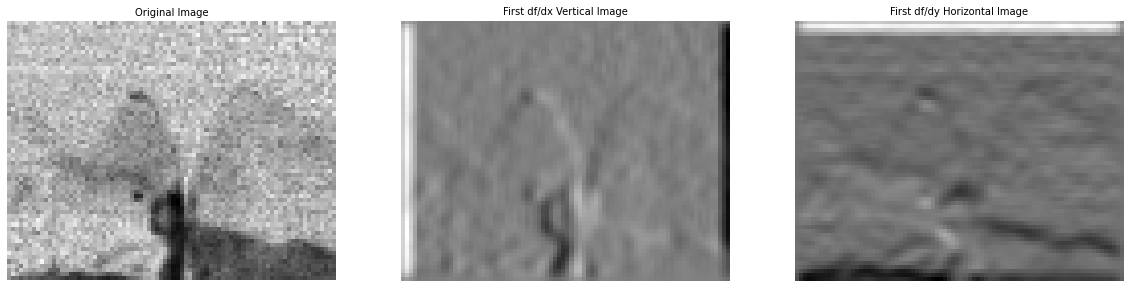

In [1118]:
# omitted first derivative images
fig, axs = plt.subplots(1,3,figsize=(20,20))

axs[0].imshow(imgData,cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original Image',fontsize='medium')

# First df/dx Vertical Image
axs[1].imshow(FVI,cmap='gray')
axs[1].axis('off')
axs[1].set_title('First df/dx Vertical Image',fontsize='medium')

# First df/dy Horizontal Image
axs[2].imshow(FHI,cmap='gray')
axs[2].axis('off')
axs[2].set_title('First df/dy Horizontal Image',fontsize='medium')
plt.show()

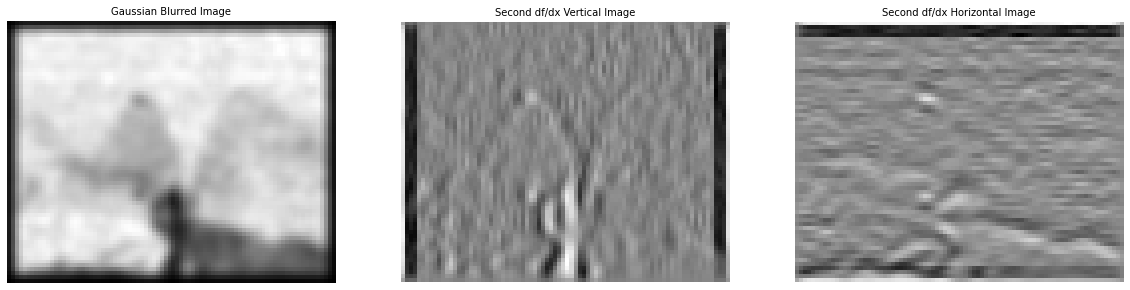

Text(0.5, 1.0, 'Second df/dx Diagonal \nTop Right to Left Bottom Image')

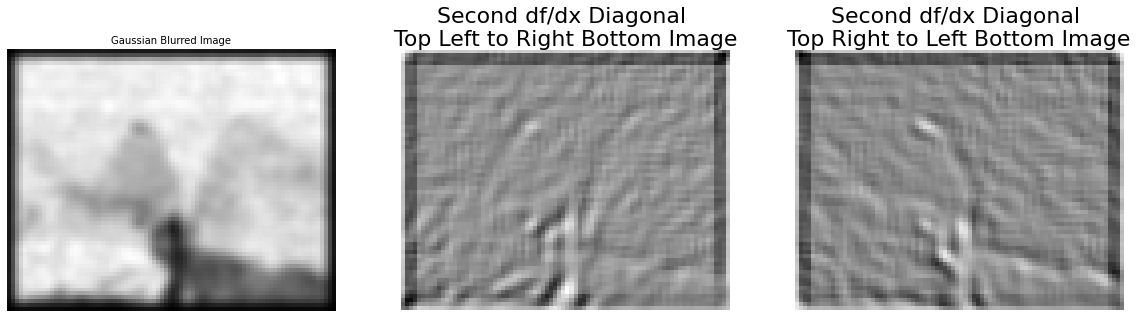

In [1119]:
# plot derivative images

fig, axs = plt.subplots(1,3,figsize=(20,20))

axs[0].imshow(Img_Matrix,cmap='gray')
axs[0].axis('off')
axs[0].set_title('Gaussian Blurred Image',fontsize='medium')

axs[1].imshow(SVI,cmap='gray')
axs[1].axis('off')
axs[1].set_title('Second df/dx Vertical Image',fontsize='medium')

axs[2].imshow(SHI,cmap='gray')
axs[2].axis('off')
axs[2].set_title('Second df/dx Horizontal Image',fontsize='medium')
plt.show()

fig, axs = plt.subplots(1,3,figsize=(20,20))

axs[0].imshow(Img_Matrix,cmap='gray')
axs[0].axis('off')
axs[0].set_title('Gaussian Blurred Image',fontsize='medium')

axs[1].imshow(SDTLI,cmap='gray')
axs[1].axis('off')
axs[1].set_title('Second df/dx Diagonal \nTop Left to Right Bottom Image',fontsize=22, loc='center', wrap=True)

axs[2].imshow(SDTRI,cmap='gray')
axs[2].axis('off')
axs[2].set_title('Second df/dx Diagonal \nTop Right to Left Bottom Image',fontsize=22, loc='center', wrap=True)


In [1120]:
# create image from minimum of all derivative images
minArray = []
for i in range(0, len(SVI)):
  newMinRow = []
  for j in range(0, len(SVI[i])):
    minimum = min(SVI[i][j], SHI[i][j], SDTLI[i][j], SDTRI[i][j])
    newMinRow.append(minimum)
    
  minArray.append(newMinRow)

(-0.5, 81.5, 64.5, -0.5)

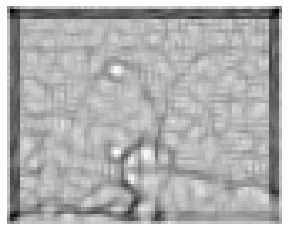

In [1121]:
plt.imshow(minArray, cmap='gray')
plt.axis('off')

In [1122]:
# normalize image
arrayMin = min(min(minArray))
normArray = minArray / (-1 * arrayMin)

In [1123]:
# threshold image, set all values above 0 to 0
for i in range(0, len(normArray)):
  for j in range(0, len(normArray[i])):
    element = normArray[i][j]
    if element >= 0:
      normArray[i][j] = 0

In [1124]:
# get the 5% minimum value of the image
flat = np.ndarray.flatten(normArray)
sortedArray = np.sort(flat)
(dim1, dim2) = normArray.shape # get dimensions of image
total_pixels = dim1 * dim2 # get total number of pixels
fivePercentMin = sortedArray[round((0.005 * total_pixels)) - 1] # get 5% minimum value

# threshold image, set all values below 5% minimum to -1, then linear stretch the rest
for i in range(0, len(normArray)):
  for j in range(0, len(normArray[i])):
    element = normArray[i][j]
    if element <= fivePercentMin:
      normArray[i][j] = -1
    else:
      normArray[i][j] = element / (-1 * fivePercentMin)
      
# no threshold, linear stretch
# normArray = NormalizeForImageSaving(normArray)

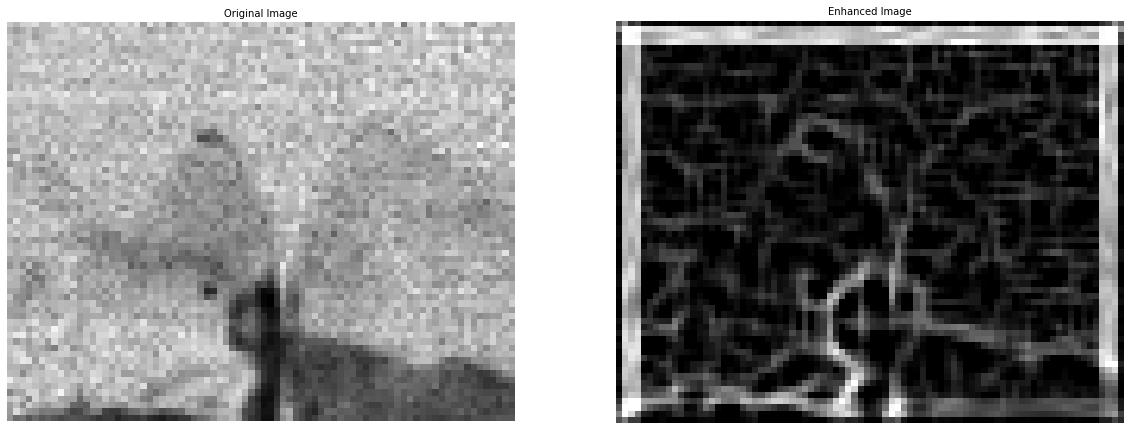

In [1125]:
fig, axs = plt.subplots(1,2,figsize=(20,20))

axs[0].imshow(imgData,cmap='gray')
axs[0].axis('off')
axs[0].set_title('Original Image',fontsize='medium')

axs[1].imshow(normArray,cmap='gray_r')
axs[1].axis('off')
axs[1].set_title('Enhanced Image',fontsize='medium')
plt.show()

In [1126]:
to_matlab_file = NormalizeForImageSaving(normArray)
# save_img = Image.fromarray(to_matlab_file)
# save_img.save('./outputs/enhanced_tooth_image' + str(img_number) + '.png')

# Super Resolution starts here

In [1127]:
to_matlab_file = (to_matlab_file - np.min(to_matlab_file)) / (np.max(to_matlab_file) - np.min(to_matlab_file))
to_matlab_file *= -1

In [1128]:
def psfmat(n, sigma):
  # create a point spread matrix with width sigma and length n
  u = [np.arange(-n, n+1)]
  v = np.exp((-(np.transpose(u)/sigma) ** 2) / 2)
  v = v / np.sum(v)
  S = np.zeros((n, n))
  nv = len(v)
  for i in range(1, n+1):
    u = n + 1
    l2 = max(n - i + 2, 1) - 1
    u2 = min(n + n - i + 1, nv)
    S[i-1][0:u] = v[l2:u2, 0]
  return S

def CG2(U, G1, G2, kappa, lmbda, delta):
  R = U
  P = R
  n1 = G1.shape[1]
  n2 = G2.shape[1]
  X = np.zeros((n1, n2))
  D1 = np.transpose(np.diff(np.eye(n1)))
  D2 = np.transpose(np.diff(np.eye(n2)))
  V1 = lmbda * np.transpose(D1) @ D1
  V2 = lmbda * np.transpose(D2) @ D2

  for it in range(1, 101):
    Q = G1 @ P @ G2 + kappa * P + V1 @ P + P @ np.transpose(V2)
    alpha = np.sum(R[:] ** 2) / np.sum(P[:] * Q[:])
    X = X + alpha * P
    Rnew = R - alpha * Q
    rs1 = np.sum(R[:] ** 2)
    rs2 = np.sum(Rnew[:] ** 2)
    beta = rs2 / rs1
    P = Rnew + beta * P
    R = Rnew
    rms = np.sqrt(rs1 / (n1 * n2))
    if rms < delta:
      break
  return X

def superresolution(img: np.ndarray, upscaleFactor) -> np.ndarray:
  (n1, n2) = img.shape
  p1 = upscaleFactor * n1
  p2 = upscaleFactor * n2
  sigma = 0.053 * upscaleFactor
  S1a = psfmat(p1, sigma)
  S2a = psfmat(p2, sigma)
  S1 = np.kron(np.eye(n1), np.ones((1, upscaleFactor))) @ S1a
  S2 = np.kron(np.eye(n2), np.ones((1, upscaleFactor))) @ S2a
  
  U = np.transpose(S1) @ img @ S2
  G1 = np.transpose(S1) @ S1
  G2 = np.transpose(S2) @ S2
  kappa = 0.01
  lmbda = 100
  delta = 0.001
  X = CG2(U, G1, G2, kappa, lmbda, delta)
  return X

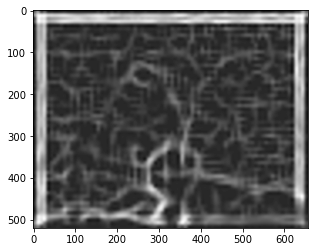

In [1129]:
sr = superresolution(to_matlab_file, 8)
plt.imshow(sr, cmap="gray")

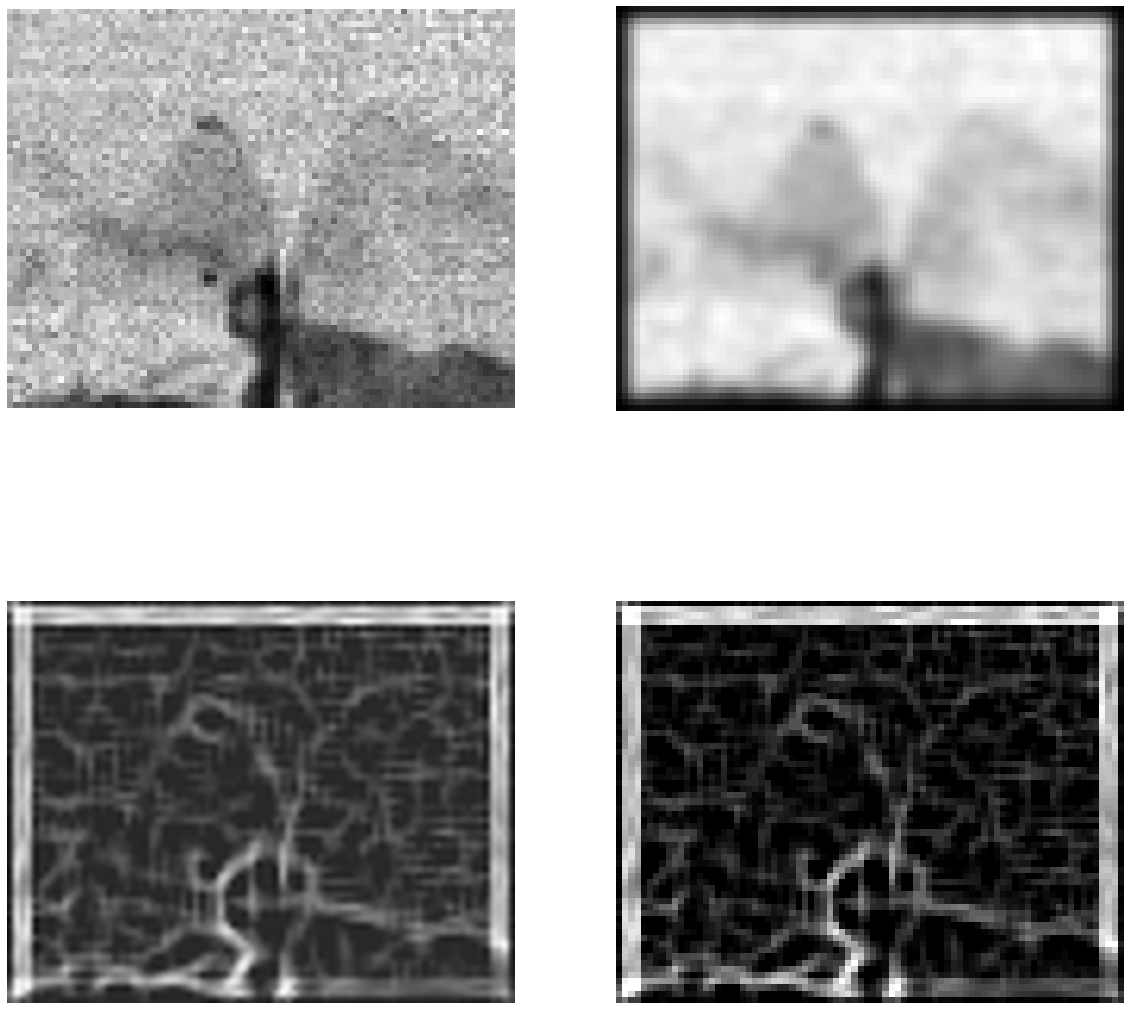

In [1130]:
finalImg = NormalizeForImageSaving(sr)
save_img = Image.fromarray(finalImg)
save_img.save('./outputs/final' + str(img_number) + '.png')

fig, axs = plt.subplots(2,2,figsize=(20,20))

axs[0, 0].imshow(imgData,cmap='gray')
axs[0, 0].axis('off')
# axs[0, 0].set_title('Original Image',fontsize='large')

axs[0, 1].imshow(gaussian,cmap='gray')
axs[0, 1].axis('off')
# axs[0, 1].set_title('Smoothed Image',fontsize='large')

axs[1, 1].imshow(to_matlab_file,cmap='gray')
axs[1, 1].axis('off')
# axs[1, 1].set_title('Detail Enhanced',fontsize='large')

axs[1, 0].imshow(sr,cmap='gray')
axs[1, 0].axis('off')
# axs[1, 0].set_title('Super Resolution',fontsize='large')
plt.show()